## Phase 2 — Airport Map to CA Grid

In this phase we introduce a simple pipeline that converts an airport diagram
into a Cellular Automaton (CA) grid. This allows us to run CA-based surface
movement models on a geometry that resembles a real airport rather than a
hand-drawn toy layout.

The main steps included in this phase are:

1. Resize the airport image to a fixed grid resolution (e.g., 200×400).
2. Apply color clustering (K-Means) to reduce noise and classify major color groups.
3. Use simple geometry heuristics to identify:
   - background area
   - apron / terminal area
   - taxiway area
   - runway area
4. Convert the image into a CA zone mask with 4 states:
   - 0 = background
   - 1 = apron
   - 2 = taxiway
   - 3 = runway
5. Crop unnecessary borders and clean small artifacts (e.g., airplane shapes).
6. Save the grid for later CA simulation.

The output of this phase is a clean CA grid mask that can be used for
movement simulation in the next step.

Raw image size: 1536 x 738


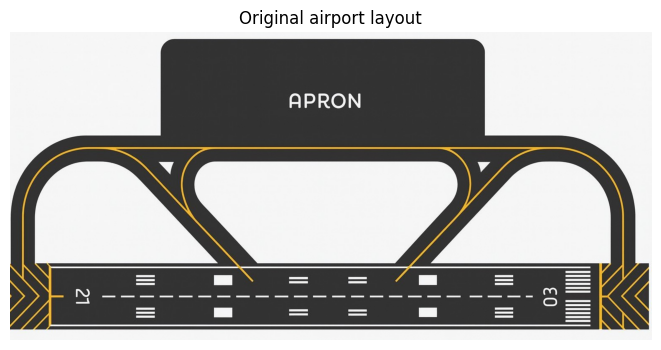

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = False

# ---- 1) Load image ----
IMG_PATH = "test5.jpg"
img_raw = Image.open(IMG_PATH).convert("RGB")
w_raw, h_raw = img_raw.size
print("Raw image size:", w_raw, "x", h_raw)

plt.imshow(img_raw)
plt.title("Original airport layout")
plt.axis("off")
plt.show()

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Resized image shape: (200, 400, 3)


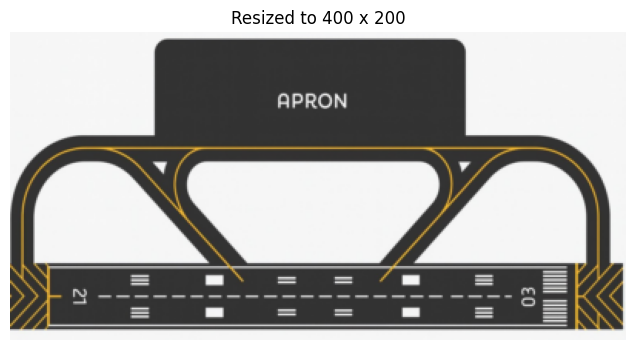

In [56]:
# ---- 2) Resize to CA grid resolution ----
GRID_H = 200   # rows
GRID_W = 400   # cols

img_resized = img_raw.resize((GRID_W, GRID_H), resample=Image.BILINEAR)
rgb = np.array(img_resized)[:, :, :3]
print("Resized image shape:", rgb.shape)

plt.imshow(img_resized)
plt.title(f"Resized to {GRID_W} x {GRID_H}")
plt.axis("off")
plt.show()

Cluster centers (RGB):
  Cluster 0: [245.62027255 245.7187566  245.70269913]
  Cluster 1: [51.67457848 51.19601742 50.35629834]
  Cluster 2: [131.99415964 131.93445814 132.00843608]
  Cluster 3: [180.55764411 143.88659148  58.11904762]
  Cluster 4: [93.38842141 86.32884551 72.15449344]
  Cluster 5: [198.62954844 198.54537484 198.40377028]

Cluster intensity / grayness:
  0: intensity=  245.7, grayness=   0.0
  1: intensity=   51.1, grayness=   0.5
  2: intensity=  132.0, grayness=   0.0
  3: intensity=  127.5, grayness=  51.3
  4: intensity=   84.0, grayness=   8.8
  5: intensity=  198.5, grayness=   0.1


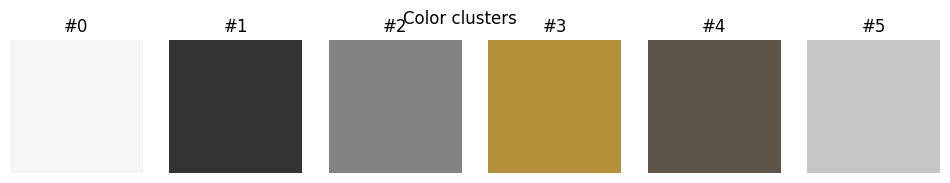

In [57]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# rgb is the resized image array of shape (GRID_H, GRID_W, 3)
# GRID_H, GRID_W already defined earlier

# ---- 3) KMeans color clustering ----
pixels = rgb.reshape(-1, 3).astype(float)

N_CLUSTERS = 6  # number of color clusters; 5–8 usually works
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0, n_init="auto")
kmeans.fit(pixels)

labels = kmeans.labels_.reshape(GRID_H, GRID_W)
centers = kmeans.cluster_centers_  # shape: (N_CLUSTERS, 3)

print("Cluster centers (RGB):")
for i, c in enumerate(centers):
    print(f"  Cluster {i}: {c}")

# Simple features of each cluster:
intensity = centers.mean(axis=1)   # overall brightness (0–255)
grayness = centers.std(axis=1)     # how far from pure gray (0 = perfectly gray)

print("\nCluster intensity / grayness:")
for i in range(N_CLUSTERS):
    print(f"  {i}: intensity={intensity[i]:7.1f}, grayness={grayness[i]:6.1f}")

# Visualize the cluster colors as small patches
fig, ax = plt.subplots(1, N_CLUSTERS, figsize=(2 * N_CLUSTERS, 2))
for i in range(N_CLUSTERS):
    patch = np.ones((20, 20, 3), dtype=float)
    patch[:] = centers[i] / 255.0
    ax[i].imshow(patch)
    ax[i].set_title(f"#{i}")
    ax[i].axis("off")
plt.suptitle("Color clusters")
plt.show()

In [58]:
# ---- 4) Heuristic mapping: cluster -> coarse zone ----
# Zones (for this step):
#   0 = background (white, planes, empty)
#   1 = apron / pavement (top dark block with stands)
#   2 = taxiway (curved roads with yellow centerlines)
#   3 = runway (bottom strip with markings)

H, W = labels.shape

# 4.1 Background clusters = very bright ones (near white)
#     intensity in [0,255], so background is roughly > 230
bg_threshold = 230.0
background_clusters = [i for i in range(N_CLUSTERS) if intensity[i] > bg_threshold]
print("Background clusters:", background_clusters)

# Non-background clusters are those used for pavement (apron/taxiway/runway)
non_bg_clusters = [i for i in range(N_CLUSTERS) if i not in background_clusters]

# 4.2 For non-background clusters, compute:
#     - total pixel count
#     - mean y-position (row index) to know whether they are high/low in the image
cluster_stats = {}
for cid in non_bg_clusters:
    ys, xs = np.where(labels == cid)
    if len(ys) == 0:
        mean_y = None
    else:
        mean_y = ys.mean()
    cluster_stats[cid] = {
        "count": len(ys),
        "mean_y": mean_y,
    }

print("\nNon-background cluster stats:")
for cid, st in cluster_stats.items():
    print(f"  cluster {cid}: count={st['count']}, mean_y={st['mean_y']:.1f}")

# 4.3 Runway cluster = among non-bg, the one with largest mean_y (lowest in the image)
runway_cluster = max(
    non_bg_clusters,
    key=lambda c: (cluster_stats[c]["mean_y"] if cluster_stats[c]["mean_y"] is not None else -1)
)
print("\nHeuristic: runway_cluster =", runway_cluster)

# 4.4 Apron cluster = non-bg & not runway, with the largest number of pixels
#     in the upper half of the image (stands/apron live there)
upper_mask = np.zeros_like(labels, dtype=bool)
upper_mask[: GRID_H // 2, :] = True

apron_candidates = [c for c in non_bg_clusters if c != runway_cluster]
upper_counts = {}
for cid in apron_candidates:
    cid_mask = (labels == cid) & upper_mask
    upper_counts[cid] = cid_mask.sum()

apron_cluster = max(apron_candidates, key=lambda c: upper_counts[c])
print("Heuristic: apron_cluster  =", apron_cluster)

# 4.5 Remaining non-bg, non-runway, non-apron clusters are interpreted as taxiway
taxiway_clusters = [
    c for c in non_bg_clusters if c not in (runway_cluster, apron_cluster)
]
print("Heuristic: taxiway_clusters =", taxiway_clusters)

# 4.6 Build cluster_to_zone mapping
cluster_to_zone = {c: 0 for c in range(N_CLUSTERS)}  # default: background
for c in background_clusters:
    cluster_to_zone[c] = 0
cluster_to_zone[runway_cluster] = 3
cluster_to_zone[apron_cluster] = 1
for c in taxiway_clusters:
    cluster_to_zone[c] = 2

print("\ncluster_to_zone mapping:")
for c in range(N_CLUSTERS):
    print(f"  cluster {c} -> zone {cluster_to_zone[c]}")

# ---- 5) Apply mapping to get initial zone_grid ----
vectorized_map = np.vectorize(lambda cid: cluster_to_zone.get(int(cid), 0))
zone_grid = vectorized_map(labels).astype(int)

print("Initial zone_grid shape:", zone_grid.shape)

Background clusters: [0]

Non-background cluster stats:
  cluster 1: count=33747, mean_y=100.5
  cluster 2: count=1541, mean_y=127.0
  cluster 3: count=1595, mean_y=125.9
  cluster 4: count=2972, mean_y=141.1
  cluster 5: count=2281, mean_y=150.7

Heuristic: runway_cluster = 5
Heuristic: apron_cluster  = 1
Heuristic: taxiway_clusters = [2, 3, 4]

cluster_to_zone mapping:
  cluster 0 -> zone 0
  cluster 1 -> zone 1
  cluster 2 -> zone 2
  cluster 3 -> zone 2
  cluster 4 -> zone 2
  cluster 5 -> zone 3
Initial zone_grid shape: (200, 400)


zone_grid shape: 200 400
zone 0: 37864 cells
zone 1: 12095 cells
zone 2: 11393 cells
zone 3: 18648 cells


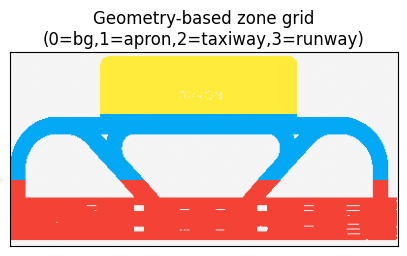

In [59]:
from matplotlib.colors import ListedColormap

# At this point, zone_grid roughly separates background vs pavement,
# but cluster-based labels may still be messy. We now enforce a simple
# geometry rule:
#   - top band of pavement = apron
#   - middle band          = taxiway
#   - bottom band          = runway

H, W = zone_grid.shape
print("zone_grid shape:", H, W)

zone_geo = np.zeros_like(zone_grid, dtype=int)

# Background remains 0
bg_mask = (zone_grid == 0)

# Pavement (all non-background cells) is temporarily treated together
pavement_mask = ~bg_mask

# Build a row index array to define top/middle/bottom bands
rows = np.arange(H).reshape(-1, 1)   # shape (H, 1)

# Fractions of the vertical extent used for bands (tune if needed)
top_threshold    = int(H * 0.32)     # upper ~34% as apron
bottom_threshold = int(H * 0.66)     # lower ~34% as runway

apron_mask  = pavement_mask & (rows <  top_threshold)
runway_mask = pavement_mask & (rows >= bottom_threshold)
twy_mask    = pavement_mask & ~(apron_mask | runway_mask)

# Assign final zones:
zone_geo[bg_mask]    = 0  # background
zone_geo[apron_mask] = 1  # apron / stands
zone_geo[twy_mask]   = 2  # taxiway
zone_geo[runway_mask]= 3  # runway

# Check class counts
vals, cnts = np.unique(zone_geo, return_counts=True)
for v, c in zip(vals, cnts):
    print(f"zone {v}: {c} cells")

# Visualize the geometry-based zoning
zone_cmap = ListedColormap([
    "#f5f5f5",  # 0: background
    "#ffeb3b",  # 1: apron
    "#03a9f4",  # 2: taxiway
    "#f44336",  # 3: runway
])

plt.figure(figsize=(5,5))
plt.imshow(zone_geo, cmap=zone_cmap, origin="upper")
plt.title("Geometry-based zone grid\n(0=bg,1=apron,2=taxiway,3=runway)")
plt.xticks([])
plt.yticks([])
plt.show()

Original shape: (200, 400)
Cropped shape : (200, 400)


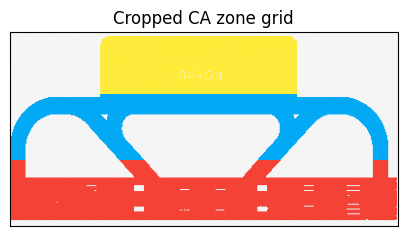

In [60]:
# ---- after geometry-based zoning (zone_geo) ----
H, W = zone_geo.shape
N_CROP = 0   # rows to remove from bottom, if needed

zone_crop = zone_geo[: H - N_CROP, :]

print("Original shape:", zone_geo.shape)
print("Cropped shape :", zone_crop.shape)

zone_cmap = ListedColormap([
    "#f5f5f5",  # 0: background
    "#ffeb3b",  # 1: apron
    "#03a9f4",  # 2: taxiway
    "#f44336",  # 3: runway
])

plt.figure(figsize=(5, 5))
plt.imshow(zone_crop, cmap=zone_cmap, origin="upper")
plt.title("Cropped CA zone grid")
plt.xticks([])
plt.yticks([])
plt.show()


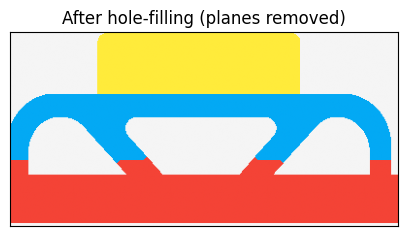

In [61]:
import scipy.ndimage as ndi
from matplotlib.colors import ListedColormap

zone_clean = zone_crop.copy()

def fill_small_holes(zone, n_iter=2):
    """
    Fill small zone==0 'holes' inside pavement by majority vote
    over their 3x3 neighborhood.

    n_iter controls how many smoothing iterations to apply:
    - small values (2–3) only remove small white regions (planes),
      without eating into large background areas.
    """
    z = zone.copy()
    H, W = z.shape

    for _ in range(n_iter):
        # For each label 1,2,3, count how many of its cells are
        # in each 3x3 neighborhood.
        counts = {}
        for val in [1, 2, 3]:
            counts[val] = ndi.convolve(
                (z == val).astype(int),
                np.ones((3, 3), dtype=int),
                mode="constant",
                cval=0,
            )

        # Candidate 'holes' are cells currently labeled 0
        mask_hole = (z == 0)
        if not mask_hole.any():
            break

        # Stack counts into shape (H, W, 3) and find the label
        # with the maximum count in each neighborhood.
        stack = np.stack([counts[1], counts[2], counts[3]], axis=-1)
        winner_idx = stack.argmax(axis=-1)   # 0->label1, 1->label2, 2->label3
        winner_val = (winner_idx + 1)        # convert to actual labels 1,2,3

        # Only update if there is at least one non-zero neighbor
        has_neighbor = stack.max(axis=-1) > 0
        update_mask = mask_hole & has_neighbor
        z[update_mask] = winner_val[update_mask]

    return z

zone_clean = fill_small_holes(zone_crop, n_iter=3)

zone_cmap = ListedColormap([
    "#f5f5f5",  # 0: background
    "#ffeb3b",  # 1: apron
    "#03a9f4",  # 2: taxiway
    "#f44336",  # 3: runway
])

plt.figure(figsize=(5,5))
plt.imshow(zone_clean, cmap=zone_cmap, origin="upper")
plt.title("After hole-filling (planes removed)")
plt.xticks([])
plt.yticks([])
plt.show()

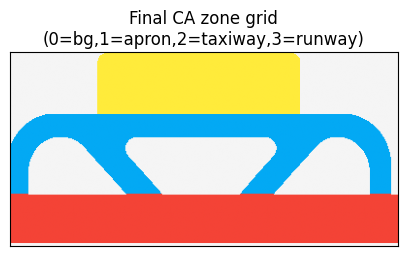

Saved final mask to zone_mask_airport_final.(npy,csv)


In [62]:
from matplotlib.colors import ListedColormap

# Start from cleaned zones
zone_final = zone_clean.copy()
H, W = zone_final.shape
rows = np.arange(H).reshape(-1, 1)

# Define fixed vertical bands (tune these numbers)
runway_top    = int(H * 0.73)   # everything from here DOWN can be runway
taxi_top      = int(H * 0.5)   # taxiway band starts here
taxi_bottom   = runway_top      # taxiway band ends just above runway band

# 1) Forbid runway above its band
zone_final[(zone_final == 3) & (rows < runway_top)] = 2   # turn red→blue above runway band

# 2) Forbid taxiway inside the runway band
zone_final[(zone_final == 2) & (rows >= runway_top)] = 3  # blue→red only in runway band

# 3) Optionally, forbid runway inside the apron band
zone_final[(zone_final == 3) & (rows < taxi_top)] = 2

# Visualize
zone_cmap = ListedColormap([
    "#f5f5f5",  # 0: background
    "#ffeb3b",  # 1: apron
    "#03a9f4",  # 2: taxiway
    "#f44336",  # 3: runway
])

plt.figure(figsize=(5,5))
plt.imshow(zone_final, cmap=zone_cmap, origin="upper")
plt.title("Final CA zone grid\n(0=bg,1=apron,2=taxiway,3=runway)")
plt.xticks([])
plt.yticks([])
plt.show()

# Save
np.save("zone_mask_airport_final.npy", zone_final)
np.savetxt("zone_mask_airport_final.csv", zone_final, fmt="%d", delimiter=",")
print("Saved final mask to zone_mask_airport_final.(npy,csv)")

## Next Steps

With the CA grid mask ready, the next tasks in Phase 2 and Phase 3 are:

1. Implement CA movement rules:
   - one-cell movement per time step
   - conflict avoidance and right-of-way logic
   - entry rules from apron to taxiway
   - slowdown rules under weather (Good / Fair / Poor)

2. Inject traffic using the same demand rates as Phase 1
   (Poisson arrivals/departures with lambda_L and lambda_T).

3. Measure CA-based performance metrics:
   - taxi-out delay
   - taxi-in delay
   - density and flow on taxiways
   - fundamental diagrams (flow–density)

4. Compare DES (Phase 1) vs CA (Phase 2):
   - delays
   - congestion onset
   - sensitivity to weather
   - bottleneck locations

5. Prepare for Phase 3:
   - runway scheduling policies (landing-first, k:1 rotation, time-window)
   - interactions between arrivals and departures on the CA surface

This sets up the full surface-movement CA model, which will eventually be
validated against the DES baseline and extended to more complex policies.

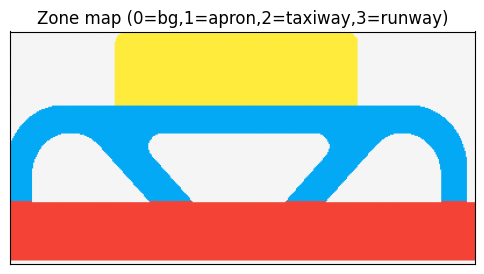

In [63]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# ------------------------------------------------
# 1. Visualize to confirm we are using the same zone / skeleton
# ------------------------------------------------
zone_cmap = ListedColormap([
    "#f5f5f5",  # 0 bg
    "#ffeb3b",  # 1 apron
    "#03a9f4",  # 2 taxiway
    "#f44336",  # 3 runway
])

plt.figure(figsize=(6, 4))
plt.imshow(zone_final, cmap=zone_cmap, origin="upper")
plt.title("Zone map (0=bg,1=apron,2=taxiway,3=runway)")
plt.xticks([]); plt.yticks([])
plt.show()

zone_final shape: 200 x 400
Taxiway cells: 15897
Skeleton pixels: 601


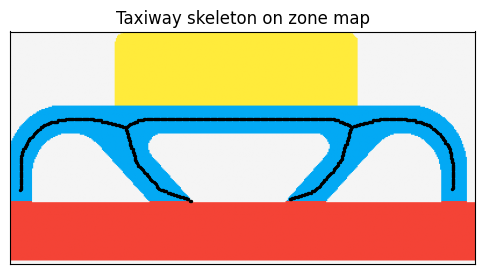

In [64]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.morphology import skeletonize

# --- 1. Zone colormap (redefined here in case variable names differ) ---
zone_cmap = ListedColormap([
    "#f5f5f5",  # 0 bg
    "#ffeb3b",  # 1 apron
    "#03a9f4",  # 2 taxiway
    "#f44336",  # 3 runway
])

H, W = zone_final.shape
print("zone_final shape:", H, "x", W)

# --- 2. Extract taxiway area (zone == 2) ---
twy_mask = (zone_final == 2)
print("Taxiway cells:", twy_mask.sum())

# --- 3. Use skeletonize to get thin lines (rough approximation of centerlines) ---
skeleton = skeletonize(twy_mask).astype(np.uint8)
print("Skeleton pixels:", skeleton.sum())

# --- 4. Plot zone + skeleton to verify the result ---
plt.figure(figsize=(6, 4))
plt.imshow(zone_final, cmap=zone_cmap, origin="upper")
ys, xs = np.where(skeleton == 1)
plt.scatter(xs, ys, s=2, c="black")
plt.title("Taxiway skeleton on zone map")
plt.xticks([]); plt.yticks([])
plt.show()

Row mode (most frequent skeleton row): 75
Row band for main taxiway: 72 to 78
Skeleton pixels in band: 289
HOLD_IN candidate on band: (np.int64(78), np.int64(33))
Runway-side skeleton endpoints: [(np.int64(135), np.int64(380)), (np.int64(136), np.int64(8)), (np.int64(144), np.int64(240)), (np.int64(145), np.int64(155))]
HOLD_OUT candidate on skeleton: (np.int64(136), np.int64(8))
Start skeleton cell (right side): (np.int64(78), np.int64(355))
End   skeleton cell (leftmost near runway): (np.int64(136), np.int64(8))


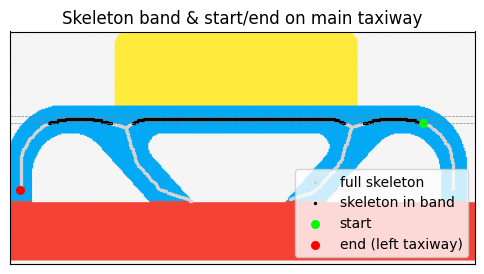

In [65]:
# --- 5. Find the skeleton "main row" (the row where it appears most frequently) ---
ys, xs = np.where(skeleton == 1)

# Build a histogram over rows to find the row with the highest count
hist, bin_edges = np.histogram(ys, bins=H, range=(0, H))
row_mode = np.argmax(hist)   # row where skeleton appears most frequently
print("Row mode (most frequent skeleton row):", row_mode)

band_half_width = 3
band_low  = max(0, row_mode - band_half_width)
band_high = min(H-1, row_mode + band_half_width)
print(f"Row band for main taxiway: {band_low} to {band_high}")

# Within the band, select skeleton points (approx main taxiway region)
candidates = [(r, c) for (r, c) in zip(ys, xs)
              if band_low <= r <= band_high]

print("Skeleton pixels in band:", len(candidates))
if not candidates:
    raise RuntimeError("No skeleton pixels found in band – need to adjust band settings.")

# ------------------------------------------------------------------
# NEW: choose start_cell and end_cell using endpoints near the runway ==========
# ------------------------------------------------------------------

# 1a) start_cell: keep using the rightmost point in the band
start_cell = max(candidates, key=lambda rc: rc[1])  # largest column -> right side

# 1b) HOLD_IN candidate on the band: leftmost band point
holdin_band = min(candidates, key=lambda rc: rc[1])  # smallest column
print("HOLD_IN candidate on band:", holdin_band)

# 2) find runway-side endpoints of the skeleton
sk_points = list(zip(ys, xs))
sk_set = set(sk_points)
runway_mask = (zone_final == 3)

def is_endpoint(r, c):
    """Skeleton endpoint: exactly 1 skeleton neighbour in 8-neighbourhood."""
    cnt = 0
    for dr in (-1, 0, 1):
        for dc in (-1, 0, 1):
            if dr == 0 and dc == 0:
                continue
            if (r+dr, c+dc) in sk_set:
                cnt += 1
    return cnt == 1

endpoints = []
for (r, c) in sk_points:
    if not is_endpoint(r, c):
        continue
    # keep only endpoints low in the image (near runway)
    if r < H * 0.4:   # tweak 0.4 if needed
        continue
    endpoints.append((r, c))

print("Runway-side skeleton endpoints:", endpoints)
if not endpoints:
    raise RuntimeError("No runway-side endpoints found; adjust height filter.")

# 3) pick the LEFTMOST of these endpoints as the leftmost taxiway tail
holdout_r, holdout_c = min(endpoints, key=lambda rc: rc[1])
HOLD_OUT_skel = (holdout_r, holdout_c)
print("HOLD_OUT candidate on skeleton:", HOLD_OUT_skel)

# 4) use this endpoint itself as end_cell for main_route
end_cell = HOLD_OUT_skel

print("Start skeleton cell (right side):", start_cell)
print("End   skeleton cell (leftmost near runway):", end_cell)

# Visualize band + start/end for verification
plt.figure(figsize=(6, 4))
plt.imshow(zone_final, cmap=zone_cmap, origin="upper")
plt.axhline(band_low,  color="gray", linestyle="--", linewidth=0.5)
plt.axhline(band_high, color="gray", linestyle="--", linewidth=0.5)

# 1) draw the full skeleton (all taxiways, including left connector)
ys_all, xs_all = np.where(skeleton == 1)
plt.scatter(xs_all, ys_all, s=2, c="lightgray", label="full skeleton")

# 2) highlight the main-route band skeleton in black
ys_band = [r for (r, c) in candidates]
xs_band = [c for (r, c) in candidates]
plt.scatter(xs_band, ys_band, s=2, c="black", label="skeleton in band")

# 3) start/end markers
plt.scatter([start_cell[1]], [start_cell[0]], c="lime", s=30, label="start")
plt.scatter([end_cell[1]],   [end_cell[0]],   c="red",  s=30, label="end (left taxiway)")

plt.title("Skeleton band & start/end on main taxiway")
plt.xticks([]); plt.yticks([])
plt.legend(loc="lower right")
plt.show()
#===============================================================================

Main route length (cells): 384
HOLD_IN index, coord: 322 (np.int64(78), np.int64(33))
HOLD_OUT index, coord: 383 (np.int64(136), np.int64(8))


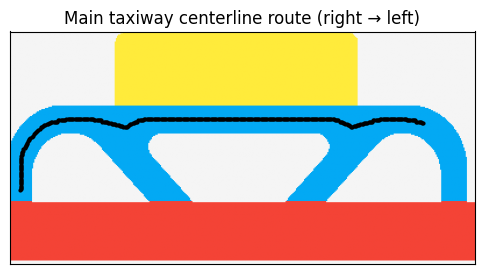

In [66]:
# --- 6. BFS on skeleton mask to get a continuous path ---

def bfs_path(start, goal, mask):
    """
    8-neighbor BFS on a boolean mask.
    mask[r,c] == True means cell is walkable (here: skeleton==1).
    """
    (sr, sc) = start
    (gr, gc) = goal

    if not (mask[sr, sc] and mask[gr, gc]):
        raise RuntimeError("Start or goal not on skeleton")

    H, W = mask.shape
    q = deque([(sr, sc)])
    prev = { (sr, sc): None }

    # 8-neighbour moves
    dirs = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]

    while q:
        r, c = q.popleft()
        if (r, c) == (gr, gc):
            break
        for dr, dc in dirs:
            rr, cc = r + dr, c + dc
            if 0 <= rr < H and 0 <= cc < W and mask[rr, cc]:
                if (rr, cc) not in prev:
                    prev[(rr, cc)] = (r, c)
                    q.append((rr, cc))

    if (gr, gc) not in prev:
        raise RuntimeError("No path found on skeleton")

    # backtrack
    path = []
    cur = (gr, gc)
    while cur is not None:
        path.append(cur)
        cur = prev[cur]
    path.reverse()
    return path

# skeleton mask
sk_mask = (skeleton == 1)

main_route = bfs_path(start_cell, end_cell, sk_mask)
print("Main route length (cells):", len(main_route))


# === HOLD_IN and HOLD_OUT on main_route =======================================
route_arr_main = np.array(main_route, dtype=int)
L_main = len(route_arr_main)

# For now: HOLD_OUT = last point of main_route (left connector endpoint)
HOLD_OUT_IDX = L_main - 1
HOLD_OUT     = tuple(route_arr_main[HOLD_OUT_IDX])

# Map band HOLD_IN candidate to nearest point on main_route
h_in_r, h_in_c = holdin_band
d2_in = (route_arr_main[:, 0] - h_in_r)**2 + (route_arr_main[:, 1] - h_in_c)**2
HOLD_IN_IDX = int(np.argmin(d2_in))
HOLD_IN     = tuple(route_arr_main[HOLD_IN_IDX])

print("HOLD_IN index, coord:", HOLD_IN_IDX, HOLD_IN)
print("HOLD_OUT index, coord:", HOLD_OUT_IDX, HOLD_OUT)
# ==============================================================================


# Visualize the main route
plt.figure(figsize=(6, 4))
plt.imshow(zone_final, cmap=zone_cmap, origin="upper")
rr, cc = zip(*main_route)
plt.scatter(cc, rr, s=4, c="black")
plt.title("Main taxiway centerline route (right → left)")
plt.xticks([]); plt.yticks([])
plt.show()

zone_final shape: 200 x 400
Apron rows range: 1 to 63
Number of apron–taxiway edge cells: 209
Chosen stand cells (row, col): [(np.int64(59), np.int64(100)), (np.int64(59), np.int64(194)), (np.int64(59), np.int64(288))]
  stand (59,100) zone = 1
  stand (59,194) zone = 1
  stand (59,288) zone = 1

Stand (59,100) -> nearest main_route point (77, 107), index 248
  path length: 19

Stand (59,194) -> nearest main_route point (75, 194), index 161
  path length: 17

Stand (59,288) -> nearest main_route point (76, 282), index 73
  path length: 18


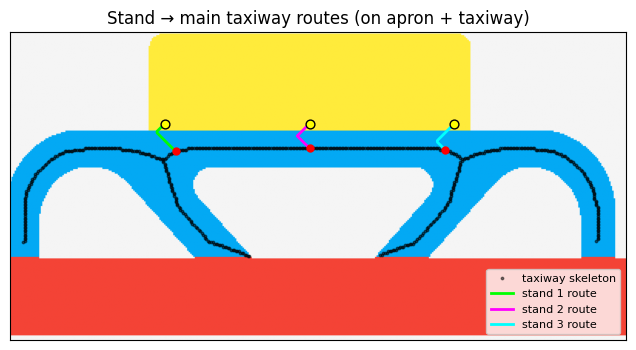

In [67]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# -------------------------------------------------------
# 0) Basic inputs & sanity checks
# -------------------------------------------------------
assert 'zone_clean' in globals(), "zone_final not found"
assert 'skeleton'   in globals(), "skeleton not found"
assert 'main_route' in globals(), "main_route (list of (r,c)) not found"

zone = zone_final
H, W = zone.shape
print(f"zone_final shape: {H} x {W}")

# 0.1 Color map (same as before)
zone_cmap = ListedColormap([
    "#f5f5f5",  # 0 bg
    "#ffeb3b",  # 1 apron
    "#03a9f4",  # 2 taxiway
    "#f44336",  # 3 runway
])

# -------------------------------------------------------
# 1) Detect apron–taxiway interface (bottom edge of apron)
# -------------------------------------------------------
apron_mask = (zone == 1)
twy_mask   = (zone == 2)

rows_with_apron = np.where(apron_mask.any(axis=1))[0]
print("Apron rows range:", rows_with_apron.min(), "to", rows_with_apron.max())

edge_cells = []
for c in range(W):
    col = zone[:, c]
    for r in range(H - 1):
        # apron cell directly above taxiway cell
        if col[r] == 1 and col[r + 1] == 2:
            edge_cells.append((r, c))
edge_cells = np.array(edge_cells)

print("Number of apron–taxiway edge cells:", len(edge_cells))

# If nothing is found, bail early
if edge_cells.size == 0:
    raise RuntimeError("No apron–taxiway edge cells found!")

# -------------------------------------------------------
# 2) Choose a few "stand" positions along this edge
#    (e.g. 3 stands across the apron width)
# -------------------------------------------------------
min_c = edge_cells[:, 1].min()
max_c = edge_cells[:, 1].max()

N_STANDS = 3
target_cols = np.linspace(min_c + 10, max_c - 10, N_STANDS, dtype=int)

stand_cells = []
for tc in target_cols:
    idx = np.argmin(np.abs(edge_cells[:, 1] - tc))
    r_edge, c_edge = edge_cells[idx]
    # Move a few cells upward so the stand is clearly inside apron
    stand_r = max(r_edge - 4, 0)
    stand_c = c_edge
    stand_cells.append((stand_r, stand_c))

print("Chosen stand cells (row, col):", stand_cells)
for (sr, sc) in stand_cells:
    print(f"  stand ({sr},{sc}) zone =", zone[sr, sc])

# -------------------------------------------------------
# 3) Prepare main_route as a NumPy array for distance calc
# -------------------------------------------------------
route_arr = np.array(main_route, dtype=int)   # shape (L, 2): [row, col]
route_rows = route_arr[:, 0]
route_cols = route_arr[:, 1]

# -------------------------------------------------------
# 4) BFS helper: shortest path on a given walkable mask
# -------------------------------------------------------
def bfs_path(start, goal, mask):
    """
    8-neighbour BFS shortest path on a binary mask.
    mask == True means walkable.
    Returns: list of (r, c) from start to goal (inclusive).
    """
    (sr, sc) = start
    (gr, gc) = goal
    if not (mask[sr, sc] and mask[gr, gc]):
        raise RuntimeError("Start or goal not walkable")

    H, W = mask.shape
    from collections import deque
    q = deque()
    q.append((sr, sc))
    prev = { (sr, sc): None }
    visited = set([(sr, sc)])

    # 8 neighbours
    nbrs = [(dr, dc) for dr in (-1, 0, 1) for dc in (-1, 0, 1)
            if not (dr == 0 and dc == 0)]

    while q:
        r, c = q.popleft()
        if (r, c) == (gr, gc):
            break
        for dr, dc in nbrs:
            rr, cc = r + dr, c + dc
            if 0 <= rr < H and 0 <= cc < W and mask[rr, cc]:
                if (rr, cc) not in visited:
                    visited.add((rr, cc))
                    prev[(rr, cc)] = (r, c)
                    q.append((rr, cc))

    if (gr, gc) not in prev and (gr, gc) != (sr, sc):
        raise RuntimeError("No BFS path found from start to goal")

    # Reconstruct path
    path = []
    cur = (gr, gc)
    while cur is not None:
        path.append(cur)
        cur = prev.get(cur, None)
    path.reverse()
    return path

# Walkable region for "stand → taxiway": apron OR taxiway
walkable_apron_twy = (zone == 1) | (zone == 2)

# -------------------------------------------------------
# 5) For each stand, find nearest main_route point
#    and compute stand → route shortest path
# -------------------------------------------------------
all_paths = []
entry_points = []

for (sr, sc) in stand_cells:
    # 5.1 nearest main_route node (Euclidean distance)
    d2 = (route_rows - sr)**2 + (route_cols - sc)**2
    idx = np.argmin(d2)
    entry = (int(route_rows[idx]), int(route_cols[idx]))
    entry_points.append(entry)
    print(f"\nStand ({sr},{sc}) -> nearest main_route point {entry}, index {idx}")

    # 5.2 BFS path on apron+taxiway
    path = bfs_path((sr, sc), entry, walkable_apron_twy)
    print("  path length:", len(path))
    all_paths.append(path)

# -------------------------------------------------------
# 6) Visualize: zone map + skeleton + stand routes
# -------------------------------------------------------
plt.figure(figsize=(8, 4))
plt.imshow(zone, cmap=zone_cmap, origin="upper")
plt.title("Stand → main taxiway routes (on apron + taxiway)")
plt.xticks([]); plt.yticks([])

# overlay skeleton
ys, xs = np.where(skeleton == 1)
plt.scatter(xs, ys, s=3, c="black", alpha=0.5, label="taxiway skeleton")

# plot each stand and its path
colors = ["lime", "magenta", "cyan", "orange", "blue"]
for i, path in enumerate(all_paths):
    rr = [p[0] for p in path]
    cc = [p[1] for p in path]
    col = colors[i % len(colors)]
    plt.plot(cc, rr, linewidth=2.0, color=col, label=f"stand {i+1} route")

# mark stands and entry points
for i, (sr, sc) in enumerate(stand_cells):
    plt.scatter(sc, sr, s=40, c="yellow", edgecolors="black", zorder=5)

for (er, ec) in entry_points:
    plt.scatter(ec, er, s=25, c="red", zorder=5)

plt.legend(loc="lower right", fontsize=8)
plt.show()

Main route length: 384
Stand cells: [(np.int64(59), np.int64(100)), (np.int64(59), np.int64(194)), (np.int64(59), np.int64(288))]
Stand (59,100) -> entry on main_route (77, 107), index 248
Stand (59,194) -> entry on main_route (75, 194), index 161
Stand (59,288) -> entry on main_route (76, 282), index 73

=== Route from stand (np.int64(59), np.int64(100)) ===
  stand -> entry length: 19
  entry -> HOLD_IN length: 75
  HOLD_IN -> HOLD_OUT length: 62
  HOLD_OUT -> runway length: 1
  total stand->runway length: 154

=== Route from stand (np.int64(59), np.int64(194)) ===
  stand -> entry length: 17
  entry -> HOLD_IN length: 162
  HOLD_IN -> HOLD_OUT length: 62
  HOLD_OUT -> runway length: 1
  total stand->runway length: 239

=== Route from stand (np.int64(59), np.int64(288)) ===
  stand -> entry length: 18
  entry -> HOLD_IN length: 250
  HOLD_IN -> HOLD_OUT length: 62
  HOLD_OUT -> runway length: 1
  total stand->runway length: 328


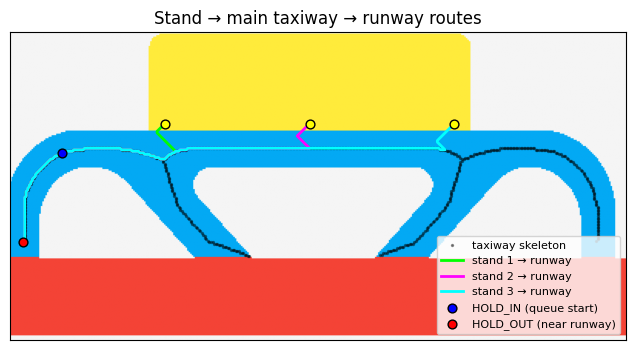

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import deque

zone = zone_final
H, W = zone.shape

zone_cmap = ListedColormap([
    "#f5f5f5",  # 0 bg
    "#ffeb3b",  # 1 apron
    "#03a9f4",  # 2 taxiway
    "#f44336",  # 3 runway
])

# -------------------------------------------------------
# 0) Rebuild main_route as array and recompute entry indices
# -------------------------------------------------------
route_arr  = np.array(main_route, dtype=int)   # shape (L,2)
route_rows = route_arr[:, 0]
route_cols = route_arr[:, 1]w

print("Main route length:", len(main_route))

# stand_cells from previous step (stand positions)
print("Stand cells:", stand_cells)

entry_points = []
entry_indices = []

for (sr, sc) in stand_cells:
    d2 = (route_rows - sr)**2 + (route_cols - sc)**2
    idx = np.argmin(d2)
    entry = (int(route_rows[idx]), int(route_cols[idx]))
    entry_points.append(entry)
    entry_indices.append(idx)
    print(f"Stand ({sr},{sc}) -> entry on main_route {entry}, index {idx}")

# -------------------------------------------------------
# 1) Find a main_route index that is "near" the runway
#    => candidate points whose 8-neighborhood contains a runway cell
# -------------------------------------------------------

# DELETED ======================================================================

# -------------------------------------------------------
# 2) BFS helper on a given walkable mask
# -------------------------------------------------------
def bfs_path(start, goal, mask):
    (sr, sc) = start
    (gr, gc) = goal
    if not (mask[sr, sc] and mask[gr, gc]):
        raise RuntimeError("Start or goal not walkable")

    H, W = mask.shape
    q = deque([(sr, sc)])
    prev = { (sr, sc): None }
    visited = set([(sr, sc)])

    nbrs = [(dr, dc) for dr in (-1, 0, 1) for dc in (-1, 0, 1)
            if not (dr == 0 and dc == 0)]

    while q:
        r, c = q.popleft()
        if (r, c) == (gr, gc):
            break
        for dr, dc in nbrs:
            rr, cc = r + dr, c + dc
            if 0 <= rr < H and 0 <= cc < W and mask[rr, cc]:
                if (rr, cc) not in visited:
                    visited.add((rr, cc))
                    prev[(rr, cc)] = (r, c)
                    q.append((rr, cc))

    if (gr, gc) not in prev and (gr, gc) != (sr, sc):
        raise RuntimeError("No BFS path from start to goal")

    path = []
    cur = (gr, gc)
    while cur is not None:
        path.append(cur)
        cur = prev.get(cur, None)
    path.reverse()
    return path

# taxiway + runway region: use this for HOLD_OUT -> actual runway cells ========
walkable_twy_runway = (zone == 2) | (zone == 3)

# -------------------------------------------------------
# 3) For each stand: build full stand→HOLD_IN→HOLD_OUT→runway route
# -------------------------------------------------------
full_routes = []

for (stand, entry, e_idx) in zip(stand_cells, entry_points, entry_indices):
    sr, sc = stand
    er, ec = entry

    print(f"\n=== Route from stand {stand} ===")

    # 3.1 stand -> entry (apron + taxiway)
    path1 = bfs_path((sr, sc), (er, ec), walkable_apron_twy)
    print("  stand -> entry length:", len(path1))

    # 3.2 main_route segment: entry index -> HOLD_IN
    if e_idx <= HOLD_IN_IDX:
        seg12 = route_arr[e_idx:HOLD_IN_IDX + 1]
    else:
        seg12 = route_arr[HOLD_IN_IDX:e_idx + 1][::-1]
    path2 = [tuple(rc) for rc in seg12]
    print("  entry -> HOLD_IN length:", len(path2))

    # 3.3 queue section HOLD_IN -> HOLD_OUT
    seg_queue = route_arr[HOLD_IN_IDX:HOLD_OUT_IDX + 1]
    path3 = [tuple(rc) for rc in seg_queue]
    print("  HOLD_IN -> HOLD_OUT length:", len(path3))

    # 3.4 from HOLD_OUT to a runway cell
    last_r, last_c = path3[-1]
    best_rwy = None
    for dr in (0, 1, 2):
        for dc in (-2, -1, 0, 1, 2):
            rr, cc = last_r + dr, last_c + dc
            if 0 <= rr < H and 0 <= cc < W and zone[rr, cc] == 3:
                best_rwy = (rr, cc)
                break
        if best_rwy is not None:
            break

    if best_rwy is None:
        print("  WARNING: no nearby runway cell found; using HOLD_OUT as final point.")
        path4 = [(last_r, last_c)]
    else:
        path4 = bfs_path((last_r, last_c), best_rwy, walkable_twy_runway)
    print("  HOLD_OUT -> runway length:", len(path4))

    full = path1 + path2[1:] + path3[1:] + path4[1:]
    print("  total stand->runway length:", len(full))
    full_routes.append(full) #==================================================


# -------------------------------------------------------
# 4) Visualize full routes
# -------------------------------------------------------
plt.figure(figsize=(8, 4))
plt.imshow(zone, cmap=zone_cmap, origin="upper")
plt.title("Stand → main taxiway → runway routes")
plt.xticks([]); plt.yticks([])

# skeleton reference
ys, xs = np.where(skeleton == 1)
plt.scatter(xs, ys, s=2, c="black", alpha=0.4, label="taxiway skeleton")

colors = ["lime", "magenta", "cyan", "orange", "blue"]

for i, route in enumerate(full_routes):
    rr = [p[0] for p in route]
    cc = [p[1] for p in route]
    col = colors[i % len(colors)]
    plt.plot(cc, rr, linewidth=2.0, color=col, label=f"stand {i+1} → runway")

# mark stands ==================================================================
for (sr, sc) in stand_cells:
    plt.scatter(sc, sr, s=40, c="yellow", edgecolors="black", zorder=5)

# mark HOLD_IN and HOLD_OUT
rin, cin = HOLD_IN
plt.scatter(cin, rin, s=40, c="blue", edgecolors="black", zorder=5, label="HOLD_IN (queue start)")

rout, cout = HOLD_OUT
plt.scatter(cout, rout, s=40, c="red", edgecolors="black", zorder=5, label="HOLD_OUT (near runway)")

plt.legend(loc="lower right", fontsize=8)
plt.show()
#===============================================================================

In [69]:
      # Convert each route in full_routes into a NumPy array
routes = [np.array(r, dtype=int) for r in full_routes]

# Each element corresponds to one stand (gate/parking position)
route1 = routes[0]   # shape: (25, 2)    stand1 -> HOLD
route2 = routes[1]   # shape: (111, 2)   stand2 -> HOLD
route3 = routes[2]   # shape: (200, 2)   stand3 -> HOLD

(r, c) = route1[i]

In [70]:
from dataclasses import dataclass
import numpy as np

@dataclass
class CATRack:
    name: str
    coords: np.ndarray    # shape (L, 2): grid coordinates of the track
    state: np.ndarray     # shape (L,): 0/1 occupancy flags along the track

    @property
    def length(self):
        return len(self.coords)

    def reset(self):
        """Clear all aircraft on this track."""
        self.state[:] = 0

    def occupied_indices(self):
        """Return the indices of all occupied cells on the track."""
        return np.where(self.state == 1)[0]


def build_ca_track(route_coords, name):
    """Build a CATRack object from a list/array of coordinates."""
    coords = np.array(route_coords, dtype=int)
    L = len(coords)
    state = np.zeros(L, dtype=int)
    return CATRack(name=name, coords=coords, state=state)

track1 = build_ca_track(full_routes[0], "Stand1_route")
track2 = build_ca_track(full_routes[1], "Stand2_route")
track3 = build_ca_track(full_routes[2], "Stand3_route")

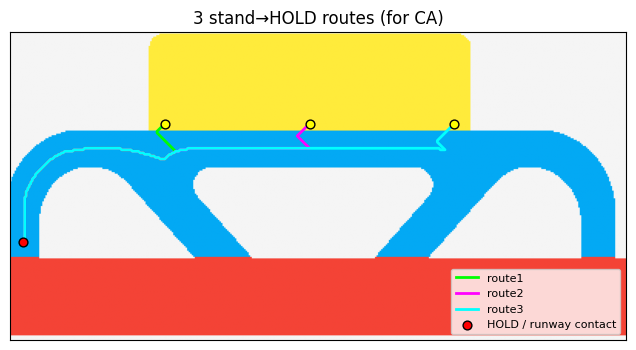

In [71]:
plt.figure(figsize=(8, 4))
plt.imshow(zone, cmap=zone_cmap, origin="upper")
plt.title("3 stand→HOLD routes (for CA)")
plt.xticks([]); plt.yticks([])

colors = ["lime", "magenta", "cyan"]

for i, route in enumerate(routes):
    rr = route[:, 0]
    cc = route[:, 1]
    # Plot each route from stand to HOLD
    plt.plot(cc, rr, linewidth=2.0, color=colors[i], label=f"route{i+1}")

# Draw stand positions
for (sr, sc) in stand_cells:
    plt.scatter(sc, sr, s=40, c="yellow", edgecolors="black", zorder=5)

# Draw HOLD / runway_contact position (use HOLD_OUT from main_route)
rrc, ccc = HOLD_OUT
plt.scatter(ccc, rrc, s=40, c="red", edgecolors="black", zorder=5,
            label="HOLD / runway contact")

plt.legend(loc="lower right", fontsize=8)
plt.show()

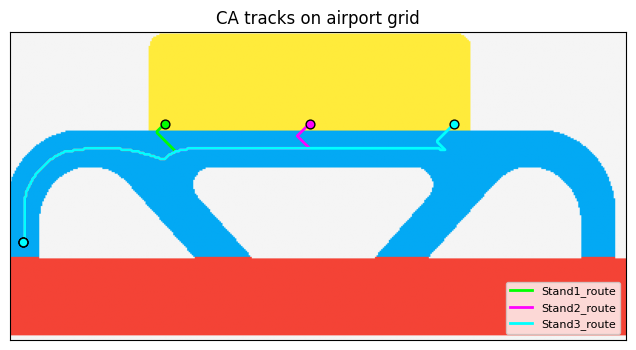

In [72]:
def plot_tracks_on_zone(zone, tracks, zone_cmap):
    plt.figure(figsize=(8, 4))
    plt.imshow(zone, cmap=zone_cmap, origin="upper")
    plt.title("CA tracks on airport grid")
    plt.xticks([]); plt.yticks([])

    colors = ["lime", "magenta", "cyan"]

    for i, track in enumerate(tracks):
        coords = track.coords
        rr = coords[:, 0]
        cc = coords[:, 1]
        col = colors[i % len(colors)]
        plt.plot(cc, rr, linewidth=2.0, color=col, label=track.name)

        # Mark the start and end points of each track
        plt.scatter(cc[0], rr[0], s=40, c=col, edgecolors="black", zorder=5)
        plt.scatter(cc[-1], rr[-1], s=40, c=col, edgecolors="black", zorder=5)

    plt.legend(loc="lower right", fontsize=8)
    plt.show()

# Usage
tracks = [track1, track2, track3]
plot_tracks_on_zone(zone, tracks, zone_cmap)

In [73]:
from dataclasses import dataclass

@dataclass
class Aircraft:
    track: CATRack        # Which CATRack this aircraft is moving on
    pos: int              # Current 1D index along the track (0..L-1)
    v: int = 0            # Current speed (cells per time step)
    vmax: int = 3         # Maximum speed (you can change to 4, 5, etc.)
    active: bool = True   # Set to False once it leaves the track

In [74]:
def nasch_step(track: CATRack, aircraft_list, p_slow=0.2):
    """
    Perform one synchronous NaSch update step on a given track for the given aircraft list.
    Only updates aircraft that belong to this track and have active=True.
    """
    # Only consider aircraft that are still on the track and belong to this track
    active_planes = [a for a in aircraft_list if a.active and (a.track is track)]
    if not active_planes:
        track.state[:] = 0
        return

    # Sort by position in ascending order (from entrance to exit)
    active_planes.sort(key=lambda a: a.pos)

    L = track.length
    n = len(active_planes)
    new_positions = [-1] * n
    new_speeds    = [0] * n

    for i, a in enumerate(active_planes):
        # 1) Acceleration
        v = min(a.v + 1, a.vmax)

        # 2) Deceleration based on distance to the aircraft in front (avoid collision)
        if i < n - 1:
            # Only check the gap if there is a preceding aircraft
            front = active_planes[i + 1]
            gap = front.pos - a.pos - 1
            if gap < 0:
                gap = 0
            v = min(v, gap)
        # For the leading aircraft (i == n-1), no gap-based speed limit:
        # if it moves beyond the track, we mark it as having left in the next step.

        # 3) Random braking
        if v > 0 and np.random.rand() < p_slow:
            v -= 1

        # 4) Position update (open boundary)
        next_pos = a.pos + v
        if next_pos >= L:
            # Aircraft leaves the track
            a.active = False
            new_positions[i] = None
            new_speeds[i]    = 0
        else:
            new_positions[i] = next_pos
            new_speeds[i]    = v

    # Synchronously write back to the track and aircraft objects
    track.state[:] = 0
    for i, a in enumerate(active_planes):
        if not a.active:
            continue
        a.pos = new_positions[i]
        a.v   = new_speeds[i]
        track.state[a.pos] = 1

In [75]:
# Assume track1, track2, track3 are already created
planes = [
    Aircraft(track=track3, pos=0, vmax=3),
    Aircraft(track=track3, pos=10, vmax=3),
]

# First clear all occupancy on track3
track3.reset()

for t in range(20):
    nasch_step(track3, planes, p_slow=0.2)
    print(f"t={t}: positions = {[a.pos for a in planes if a.active]}")

t=0: positions = [0, 11]
t=1: positions = [1, 13]
t=2: positions = [3, 16]
t=3: positions = [6, 19]
t=4: positions = [8, 22]
t=5: positions = [10, 25]
t=6: positions = [13, 28]
t=7: positions = [16, 31]
t=8: positions = [19, 34]
t=9: positions = [21, 36]
t=10: positions = [24, 39]
t=11: positions = [27, 42]
t=12: positions = [29, 45]
t=13: positions = [32, 48]
t=14: positions = [35, 51]
t=15: positions = [38, 54]
t=16: positions = [40, 57]
t=17: positions = [43, 60]
t=18: positions = [45, 63]
t=19: positions = [48, 66]


In [76]:
import matplotlib.pyplot as plt

def plot_track_with_planes(track, zone, zone_cmap, planes, title=""):
    plt.figure(figsize=(8, 4))
    plt.imshow(zone, cmap=zone_cmap, origin="upper")
    plt.xticks([]); plt.yticks([])

    # Plot the track polyline
    rr = track.coords[:, 0]
    cc = track.coords[:, 1]
    plt.plot(cc, rr, linewidth=2, color="cyan", alpha=0.7, label=track.name)

    # Plot aircraft positions (only active aircraft on this track)
    for a in planes:
        if not a.active or a.track is not track:
            continue
        r, c = track.coords[a.pos]
        plt.scatter(c, r, s=60, edgecolors="black", facecolors="white", zorder=5)

    if title:
        plt.title(title)
    plt.legend(loc="lower right", fontsize=8)
    plt.show()

t=0: positions = [1, 11]


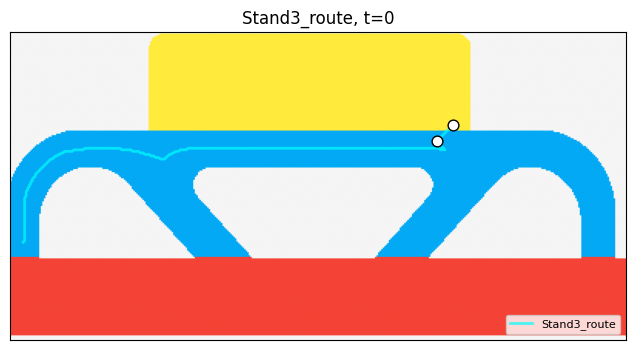

t=1: positions = [2, 13]
t=2: positions = [4, 16]
t=3: positions = [6, 19]
t=4: positions = [9, 22]
t=5: positions = [12, 25]


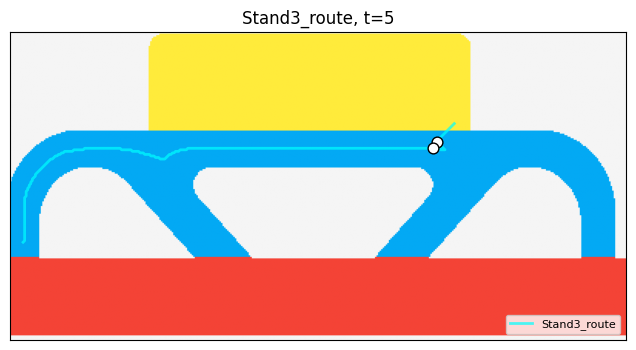

t=6: positions = [15, 28]
t=7: positions = [18, 31]
t=8: positions = [21, 34]
t=9: positions = [23, 37]
t=10: positions = [26, 40]


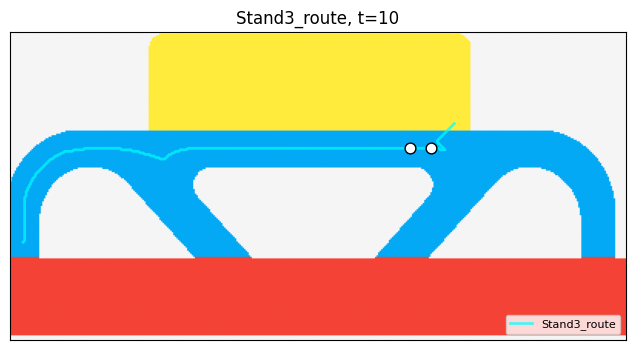

t=11: positions = [29, 43]
t=12: positions = [32, 46]
t=13: positions = [34, 48]
t=14: positions = [36, 51]
t=15: positions = [38, 54]


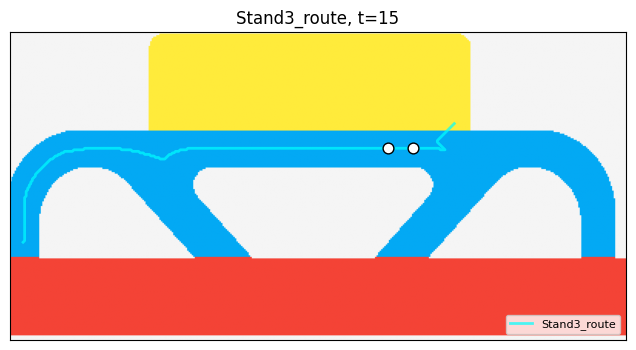

t=16: positions = [41, 57]
t=17: positions = [43, 60]
t=18: positions = [46, 63]
t=19: positions = [49, 66]


In [77]:
# Prepare two test aircraft
track3.reset()
planes = [
    Aircraft(track=track3, pos=0,  vmax=3),
    Aircraft(track=track3, pos=10, vmax=3),
]

for t in range(20):
    nasch_step(track3, planes, p_slow=0.2)
    print(f"t={t}: positions = {[a.pos for a in planes if a.active]}")

    # Plot every 5 steps
    if t % 5 == 0:
        plot_track_with_planes(
            track3, zone, zone_cmap, planes,
            title=f"Stand3_route, t={t}"
        )

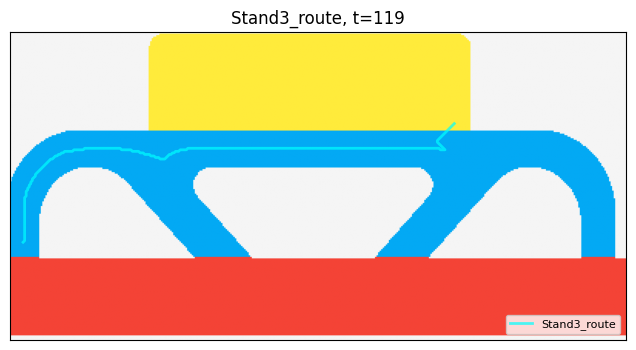

In [78]:
from IPython.display import clear_output

# Reset track3 before the simulation
track3.reset()

# Initialize two test aircraft on track3
planes = [
    Aircraft(track=track3, pos=0,  vmax=3),
    Aircraft(track=track3, pos=10, vmax=3),
]

# Run and visualize the NaSch simulation as an animation
for t in range(120):
    nasch_step(track3, planes, p_slow=0.2)

    # Clear previous frame in the notebook output
    clear_output(wait=True)

    # Plot current positions of aircraft on the track
    plot_track_with_planes(
        track3, zone, zone_cmap, planes,
        title=f"Stand3_route, t={t}"
    )

    plt.show()

In [79]:
"""# @title
import time
from IPython.display import clear_output

track3.reset()
planes = [
    Aircraft(track=track3, pos=0,  vmax=3),
    Aircraft(track=track3, pos=10, vmax=3),
]

T  = 120
dt = 0.1

for t in range(T):
    nasch_step(track3, planes, p_slow=0.2)
    clear_output(wait=True)
    plot_track_with_planes(
        track3, zone, zone_cmap, planes,
        title=f"Stand3_route, t={t}"
    )
    time.sleep(dt)"""

'# @title\nimport time\nfrom IPython.display import clear_output\n\ntrack3.reset()\nplanes = [\n    Aircraft(track=track3, pos=0,  vmax=3),\n    Aircraft(track=track3, pos=10, vmax=3),\n]\n\nT  = 120\ndt = 0.1\n\nfor t in range(T):\n    nasch_step(track3, planes, p_slow=0.2)\n    clear_output(wait=True)\n    plot_track_with_planes(\n        track3, zone, zone_cmap, planes,\n        title=f"Stand3_route, t={t}"\n    )\n    time.sleep(dt)'

In [1]:
import numpy as np
from dataclasses import dataclass

# ---- Global parameters / capacities ----
MAX_QUEUE_CAPACITY_SINGLE = 6    # queue between HOLD_IN and HOLD_OUT on track3
MAX_QUEUE_CAPACITY_MAIN   = 20   # queue between HOLD_IN and HOLD_OUT on main track

# ---- Data structures ----
@dataclass
class Aircraft:
    track: CATRack
    pos: int
    v: int = 0
    vmax: int = 3
    active: bool = True
    t_entry: int = 0              # Time step when the aircraft enters the track
    t_exit: int | None = None     # Time step when the aircraft leaves the track

NameError: name 'CATRack' is not defined

In [81]:
import numpy as np

def simulate_single_track(track: CATRack,
                          HOLD_IN_IDX: int,
                          HOLD_OUT_IDX: int,
                          T=3600,
                          lam=0.1,
                          vmax=3,
                          p_slow=0.2,
                          seed=None):
    """
    CA simulation on a single CATRack with a defined queue segment.

    Definitions:
      - t_entry   : time when aircraft appears at gate (track index 0)
      - t_hold_out: time when aircraft first reaches HOLD_OUT_IDX

    Metrics:
      - taxi_out_time = t_hold_out - t_entry      (gate -> HOLD_OUT)
      - queue_len[t]  = # active aircraft with HOLD_IN_IDX <= pos <= HOLD_OUT_IDX
    """
    if seed is not None:
        np.random.seed(seed)

    assert 0 <= HOLD_IN_IDX <= HOLD_OUT_IDX < track.length

    track.reset()
    aircraft_list: list[Aircraft] = []

    queue_len = np.zeros(T, dtype=int)

    for t in range(T):
        # --- 1) Current queue occupancy between HOLD_IN and HOLD_OUT ---
        current_queue = sum(
            a.active and (a.track is track) and
            (HOLD_IN_IDX <= a.pos <= HOLD_OUT_IDX)
            for a in aircraft_list
        )

        # --- 2) Gate pushback at index 0, only if queue below capacity ---
        wants_pushback = (np.random.rand() < lam)
        if wants_pushback and (track.state[0] == 0) and (current_queue < MAX_QUEUE_CAPACITY_SINGLE):
            a = Aircraft(track=track, pos=0, vmax=vmax,
                         t_entry=t, active=True)
            a.t_hold_out = None
            aircraft_list.append(a)
            # track.state[0] will be refreshed by nasch_step

        # --- 3) NaSch motion update ---
        nasch_step(track, aircraft_list, p_slow=p_slow)

        # --- 4) Update per-aircraft times ---
        for a in aircraft_list:
            if a.active:
                if (getattr(a, "t_hold_out", None) is None) and (a.pos >= HOLD_OUT_IDX):
                    a.t_hold_out = t
            else:
                if a.t_exit is None:
                    a.t_exit = t

        # --- 5) Queue length strictly on [HOLD_IN_IDX, HOLD_OUT_IDX] ---
        queue_len[t] = sum(
            a.active and (a.track is track) and
            (HOLD_IN_IDX <= a.pos <= HOLD_OUT_IDX)
            for a in aircraft_list
        )

    # ----- Metrics -----
    finished = [a for a in aircraft_list if getattr(a, "t_hold_out", None) is not None]

    if finished:
        taxi_times = np.array([a.t_hold_out - a.t_entry for a in finished])
        avg_taxi_time = float(taxi_times.mean())
        delay_dist = taxi_times
    else:
        avg_taxi_time = np.nan
        delay_dist = np.array([])

    sim_hours = T / 3600.0
    throughput_per_hour = len(finished) / sim_hours if sim_hours > 0 else 0.0

    results = {
        "aircraft": aircraft_list,
        "finished": finished,
        "queue_len": queue_len,
        "avg_taxi_time": avg_taxi_time,
        "delay_dist": delay_dist,
        "throughput_per_hour": throughput_per_hour,
        "T": T,
        "lam": lam,
        "HOLD_IN_IDX": HOLD_IN_IDX,
        "HOLD_OUT_IDX": HOLD_OUT_IDX,
    }
    return results

In [82]:
# --- Map HOLD_IN / HOLD_OUT (2D) to indices on track3 ---
coords3 = track3.coords  # shape (L, 2): (row, col)

matches_in = np.where(
    (coords3[:, 0] == HOLD_IN[0]) & (coords3[:, 1] == HOLD_IN[1])
)[0]
if len(matches_in) == 0:
    raise RuntimeError("HOLD_IN not found on track3")
HOLD_IN_IDX_3 = int(matches_in[0])

matches_out = np.where(
    (coords3[:, 0] == HOLD_OUT[0]) & (coords3[:, 1] == HOLD_OUT[1])
)[0]
if len(matches_out) == 0:
    raise RuntimeError("HOLD_OUT not found on track3")
HOLD_OUT_IDX_3 = int(matches_out[0])

print("HOLD_IN_IDX_3:", HOLD_IN_IDX_3, "HOLD_OUT_IDX_3:", HOLD_OUT_IDX_3)

# --- Run the simulation on track3 using those indices ---
res = simulate_single_track(
    track3,
    HOLD_IN_IDX=HOLD_IN_IDX_3,
    HOLD_OUT_IDX=HOLD_OUT_IDX_3,
    T=3600,      # 1 hour
    lam=0.1,     # pushback probability per second
    vmax=3,
    p_slow=0.2,
    seed=0,
)

print("Average taxi-out time (s):", res["avg_taxi_time"])
print("Throughput (aircraft/hour):", res["throughput_per_hour"])
print("Total number of completed aircraft:", len(res["finished"]))

HOLD_IN_IDX_3: 266 HOLD_OUT_IDX_3: 327
Average taxi-out time (s): 117.81451612903226
Throughput (aircraft/hour): 124.0
Total number of completed aircraft: 124


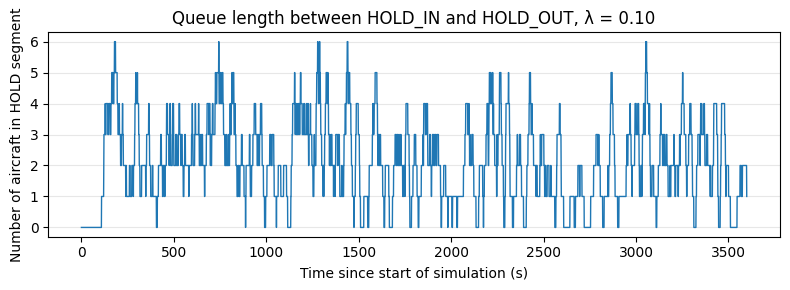

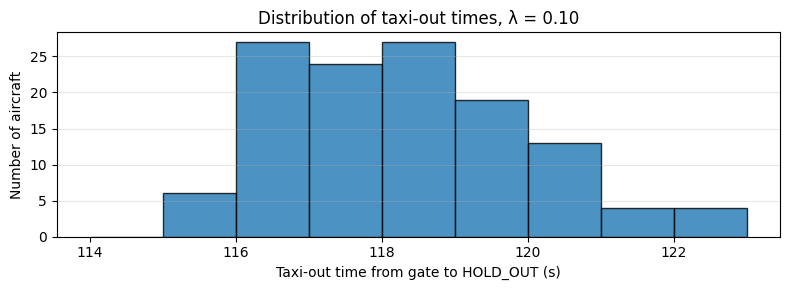

In [83]:
import numpy as np
from scipy.ndimage import uniform_filter1d  # if available

# 1) Queue length near the HOLD point over time
plt.figure(figsize=(8, 3))
plt.plot(res["queue_len"], linewidth=1)

plt.xlabel("Time since start of simulation (s)")
plt.ylabel("Number of aircraft in HOLD segment")
plt.title(f"Queue length between HOLD_IN and HOLD_OUT, λ = {res['lam']:.2f}")

plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()



# 2) Distribution of taxi-out times
if len(res["delay_dist"]) > 0:
    delays = res["delay_dist"]

    plt.figure(figsize=(8, 3))
    plt.hist(delays, bins=range(int(delays.min()) - 1,
                                int(delays.max()) + 2),
             edgecolor="black", alpha=0.8)

    plt.xlabel("Taxi-out time from gate to HOLD_OUT (s)")
    plt.ylabel("Number of aircraft")
    plt.title(f"Distribution of taxi-out times, λ = {res['lam']:.2f}")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

In [84]:
# Compute HOLD indices ONCE (before the loop)
coords3 = track3.coords
matches_in = np.where((coords3[:, 0] == HOLD_IN[0]) & (coords3[:, 1] == HOLD_IN[1]))[0]
if len(matches_in) == 0:
    raise RuntimeError("HOLD_IN not found on track3")
HOLD_IN_IDX_3 = int(matches_in[0])

matches_out = np.where((coords3[:, 0] == HOLD_OUT[0]) & (coords3[:, 1] == HOLD_OUT[1]))[0]
if len(matches_out) == 0:
    raise RuntimeError("HOLD_OUT not found on track3")
HOLD_OUT_IDX_3 = int(matches_out[0])

print("HOLD_IN_IDX_3:", HOLD_IN_IDX_3, "HOLD_OUT_IDX_3:", HOLD_OUT_IDX_3)

# Parametric sweep
lam_list = [0.02, 0.05, 0.08, 0.10, 0.12, 0.15, 0.18, 0.20, 0.25, 0.30]
avg_taxi_times = []
throughputs = []
mean_queues = []

for lam in lam_list:
    print("Simulating λ =", lam)
    res = simulate_single_track(track3,              # Use track3
                               HOLD_IN_IDX=HOLD_IN_IDX_3,   # Fixed indices
                               HOLD_OUT_IDX=HOLD_OUT_IDX_3, # Fixed indices
                               T=3600,
                               lam=lam,
                               vmax=3,
                               p_slow=0.2,
                               seed=0)

    avg_taxi_times.append(res["avg_taxi_time"])
    throughputs.append(res["throughput_per_hour"])
    mean_queues.append(res["queue_len"].mean())

HOLD_IN_IDX_3: 266 HOLD_OUT_IDX_3: 327
Simulating λ = 0.02
Simulating λ = 0.05
Simulating λ = 0.08
Simulating λ = 0.1
Simulating λ = 0.12
Simulating λ = 0.15
Simulating λ = 0.18
Simulating λ = 0.2
Simulating λ = 0.25
Simulating λ = 0.3


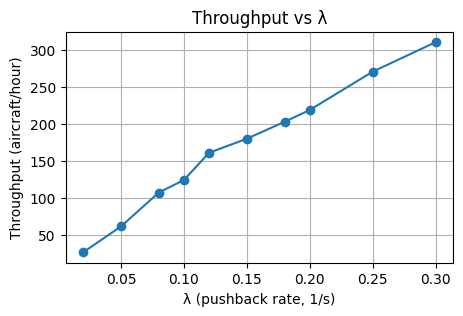

In [85]:
plt.figure(figsize=(5,3))
plt.plot(lam_list, throughputs, marker="o")
plt.xlabel("λ (pushback rate, 1/s)")
plt.ylabel("Throughput (aircraft/hour)")
plt.title("Throughput vs λ")
plt.grid(True)
plt.show()

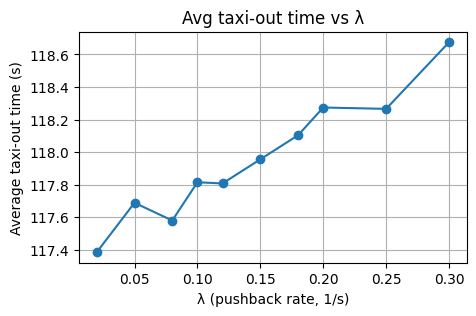

In [86]:
plt.figure(figsize=(5,3))
plt.plot(lam_list, avg_taxi_times, marker="o")
plt.xlabel("λ (pushback rate, 1/s)")
plt.ylabel("Average taxi-out time (s)")
plt.title("Avg taxi-out time vs λ")
plt.grid(True)
plt.show()

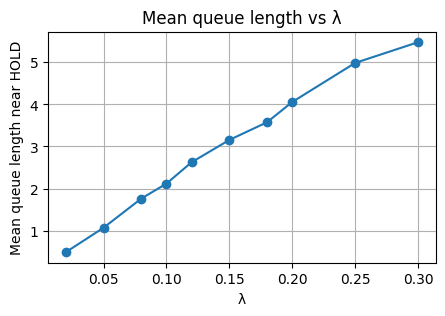

In [87]:
plt.figure(figsize=(5,3))
plt.plot(lam_list, mean_queues, marker="o")
plt.xlabel("λ")
plt.ylabel("Mean queue length near HOLD")
plt.title("Mean queue length vs λ")
plt.grid(True)
plt.show()

In [88]:
#  is already a list of (r, c) coordinates (defined above)
track_main = build_ca_track(main_route, "Main_taxiway")

# entry_indices contains the entry indices on main_route for the three stands
# e.g. something like [76, 165, 253]; we just reuse it here
entry_indices_main = entry_indices   # Make sure this is a list[int] of length 3
print("Entry indices on main route:", entry_indices_main)

# Map HOLD_IN / HOLD_OUT onto the main taxiway
coords_main = track_main.coords

matches_in_main = np.where(
    (coords_main[:, 0] == HOLD_IN[0]) & (coords_main[:, 1] == HOLD_IN[1])
)[0]
if len(matches_in_main) == 0:
    raise RuntimeError("HOLD_IN not found on main track")
HOLD_IN_IDX_MAIN = int(matches_in_main[0])

matches_out_main = np.where(
    (coords_main[:, 0] == HOLD_OUT[0]) & (coords_main[:, 1] == HOLD_OUT[1])
)[0]
if len(matches_out_main) == 0:
    raise RuntimeError("HOLD_OUT not found on main track")
HOLD_OUT_IDX_MAIN = int(matches_out_main[0])

print("HOLD_IN_IDX_MAIN:", HOLD_IN_IDX_MAIN, "HOLD_OUT_IDX_MAIN:", HOLD_OUT_IDX_MAIN)

Entry indices on main route: [np.int64(248), np.int64(161), np.int64(73)]
HOLD_IN_IDX_MAIN: 322 HOLD_OUT_IDX_MAIN: 383


In [89]:
def simulate_multi_entry(track: CATRack,
                         entry_indices,
                         HOLD_IN_IDX,
                         HOLD_OUT_IDX,
                         T=3600,
                         lam_per_entry=0.05,
                         vmax=1,
                         p_slow=0.6,
                         seed=None):
    """
    Main taxiway with multiple entry points.
    Queue is measured between HOLD_IN_IDX and HOLD_OUT_IDX.
    Taxi-out time is from gate (entry) to HOLD_OUT_IDX.
    """
    if seed is not None:
        np.random.seed(seed)

    track.reset()
    aircraft_list: list[Aircraft] = []

    queue_len = np.zeros(T, dtype=int)

    for t in range(T):
        # --- 1) Shared queue occupancy between HOLD_IN and HOLD_OUT ---
        current_queue = sum(
            a.active and (a.track is track) and
            (HOLD_IN_IDX <= a.pos <= HOLD_OUT_IDX)
            for a in aircraft_list
        )

        # --- 2) Try pushback at each entry, but cap by shared capacity ---
        for idx in entry_indices:
            wants_pushback = (np.random.rand() < lam_per_entry)
            if wants_pushback and (track.state[idx] == 0) and (current_queue < MAX_QUEUE_CAPACITY_MAIN):
                a = Aircraft(track=track, pos=idx, vmax=vmax,
                             t_entry=t, active=True)
                a.t_hold_out = None
                aircraft_list.append(a)
                # one more aircraft will enter the queue area eventually
                current_queue += 1  # conservative increment so we do not overshoot capacity this step

        # --- 3) Update motion ---
        nasch_step(track, aircraft_list, p_slow=p_slow)

        # --- 4) Update times ---
        for a in aircraft_list:
            if a.active:
                if (a.t_hold_out is None) and (a.pos >= HOLD_OUT_IDX):
                    a.t_hold_out = t
            else:
                if a.t_exit is None:
                    a.t_exit = t

        # --- 5) Queue strictly in [HOLD_IN_IDX, HOLD_OUT_IDX] ---
        queue_len[t] = sum(
            a.active and (a.track is track) and
            (HOLD_IN_IDX <= a.pos <= HOLD_OUT_IDX)
            for a in aircraft_list
        )

    # ----- Metrics -----
    finished = [a for a in aircraft_list if a.t_hold_out is not None]
    if finished:
        taxi_times = np.array([a.t_hold_out - a.t_entry for a in finished])
        avg_taxi_time = float(taxi_times.mean())
        delay_dist = taxi_times
    else:
        avg_taxi_time = np.nan
        delay_dist = np.array([])

    sim_hours = T / 3600.0
    throughput_per_hour = len(finished) / sim_hours if sim_hours > 0 else 0.0

    results = {
        "aircraft": aircraft_list,
        "finished": finished,
        "queue_len": queue_len,
        "avg_taxi_time": avg_taxi_time,      # gate -> HOLD_OUT
        "delay_dist": delay_dist,
        "throughput_per_hour": throughput_per_hour,
        "T": T,
        "lam_per_entry": lam_per_entry,
        "num_entries": len(entry_indices),
    }
    return results

In [90]:
track = track_main  # main taxiway

# λ per entry from 0.02 to 0.20 with step 0.01
lam_list = [i / 100 for i in range(2, 21)]

avg_taxi_times = []
throughputs = []
mean_queues = []

for lam in lam_list:
    print("Simulating λ_per_entry =", lam)
    res = simulate_multi_entry(track,
                               entry_indices=entry_indices_main,
                               HOLD_IN_IDX=HOLD_IN_IDX_MAIN,
                               HOLD_OUT_IDX=HOLD_OUT_IDX_MAIN,
                               T=3600,
                               lam_per_entry=lam,
                               vmax=1,
                               p_slow=0.6,
                               seed=0)
    avg_taxi_times.append(res["avg_taxi_time"])
    throughputs.append(res["throughput_per_hour"])
    mean_queues.append(res["queue_len"].mean())

Simulating λ_per_entry = 0.02
Simulating λ_per_entry = 0.03
Simulating λ_per_entry = 0.04
Simulating λ_per_entry = 0.05
Simulating λ_per_entry = 0.06
Simulating λ_per_entry = 0.07
Simulating λ_per_entry = 0.08
Simulating λ_per_entry = 0.09
Simulating λ_per_entry = 0.1
Simulating λ_per_entry = 0.11
Simulating λ_per_entry = 0.12
Simulating λ_per_entry = 0.13
Simulating λ_per_entry = 0.14
Simulating λ_per_entry = 0.15
Simulating λ_per_entry = 0.16
Simulating λ_per_entry = 0.17
Simulating λ_per_entry = 0.18
Simulating λ_per_entry = 0.19
Simulating λ_per_entry = 0.2


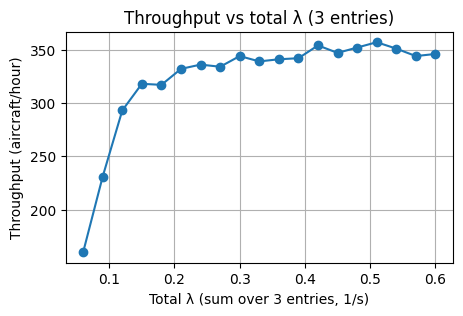

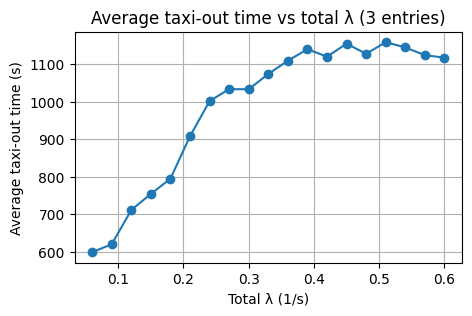

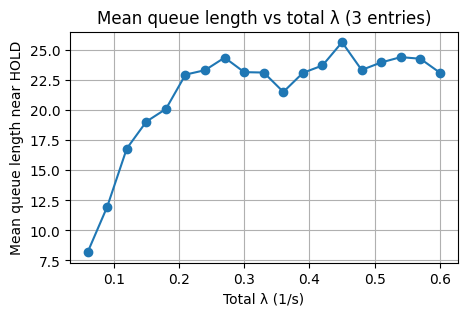

In [91]:
total_lam = [3 * lam for lam in lam_list]

# Throughput vs total λ
plt.figure(figsize=(5, 3))
plt.plot(total_lam, throughputs, marker="o")
plt.xlabel("Total λ (sum over 3 entries, 1/s)")
plt.ylabel("Throughput (aircraft/hour)")
plt.title("Throughput vs total λ (3 entries)")
plt.grid(True)
plt.show()

# Average taxi-out time vs total λ
plt.figure(figsize=(5, 3))
plt.plot(total_lam, avg_taxi_times, marker="o")
plt.xlabel("Total λ (1/s)")
plt.ylabel("Average taxi-out time (s)")
plt.title("Average taxi-out time vs total λ (3 entries)")
plt.grid(True)
plt.show()

# Mean queue length vs total λ
plt.figure(figsize=(5, 3))
plt.plot(total_lam, mean_queues, marker="o")
plt.xlabel("Total λ (1/s)")
plt.ylabel("Mean queue length near HOLD")
plt.title("Mean queue length vs total λ (3 entries)")
plt.grid(True)
plt.show()

Next steps:

A) Multi-Entry Taxiway Animation (Visualization Upgrade)

We can create a full dynamic animation showing all three stands injecting aircraft onto the main taxiway.
The animation would visualize:
	•	simultaneous pushback from three independent entry points
	•	merging behavior on the main taxiway
	•	queue formation near the runway hold point
	•	congestion propagation over time

This produces a highly intuitive and presentation-ready visualization of both free-flow and congested states.

⸻

B) Phase Diagram / Fundamental Diagram (Scientific Analysis)

We can conduct a more formal statistical-physics analysis by generating:
	•	flow–density diagrams
	•	average delay vs. demand curves
	•	queue length vs. demand curves
	•	identification of the critical demand λ* where congestion occurs

This produces publication-quality diagrams commonly used in aviation flow management and traffic science.

⸻

C) Multi-Runway or Multi-Taxiway Extensions (Operational Realism)

We can expand the current model to include:
	•	multiple taxiway branches
	•	intersections with priority rules
	•	runway crossings
	•	multiple runways with different operational modes

This direction increases the operational realism and allows evaluation of complex airport layouts.

⸻

D) Advanced Congestion Phenomena (Research-Level Features)

We can tune or extend the CA dynamics to study higher-order behaviors such as:
	•	stop-and-go waves
	•	shockwave propagation along the taxiway
	•	unstable vs. metastable flow conditions
	•	capacity drop effects

These behaviors are of strong interest in both air traffic management research and statistical physics.
